In [70]:
import numpy as np
import random
import json

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from nltk_utils import bag_of_words, tokenize, stem
from model import NeuralNet
import nltk
nltk.download('punkt')

with open('intents.json', 'r') as f:
    intents = json.load(f)

all_words = []
tags = []
xy = []
for intent in intents['intents']:
    tag = intent['tag']
    tags.append(tag)
    for pattern in intent['patterns']:
        w = tokenize(pattern)
        all_words.extend(w)
        xy.append((w, tag))

ignore_words = ['?', '.', '!']
all_words = [stem(w) for w in all_words if w not in ignore_words]
all_words = sorted(set(all_words))
tags = sorted(set(tags))

print(len(xy), "patterns")
print(len(tags), "tags:", tags)
print(len(all_words), "unique stemmed words:", all_words)

X_train = []
y_train = []
for (pattern_sentence, tag) in xy:
    bag = bag_of_words(pattern_sentence, all_words)
    X_train.append(bag)
    label = tags.index(tag)
    y_train.append(label)

X_train = np.array(X_train)
y_train = np.array(y_train)

# Hyper-parameters 
num_epochs = 1000
batch_size = 8
learning_rate = 0.001
input_size = len(X_train[0])
hidden_size = 8
output_size = len(tags)
print(input_size, output_size)

class ChatDataset(Dataset):

    def __init__(self):
        self.n_samples = len(X_train)
        self.x_data = X_train
        self.y_data = y_train
    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]
    def __len__(self):
        return self.n_samples

dataset = ChatDataset()
train_loader = DataLoader(dataset=dataset,
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=0)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = NeuralNet(input_size, hidden_size, output_size).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    for (words, labels) in train_loader:
        words = words.to(device)
        labels = labels.to(dtype=torch.long).to(device)
        outputs = model(words)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    if (epoch+1) % 100 == 0:
        print (f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


print(f'final loss: {loss.item():.4f}')

data = {
"model_state": model.state_dict(),
"input_size": input_size,
"hidden_size": hidden_size,
"output_size": output_size,
"all_words": all_words,
"tags": tags
}

FILE = "data.pth"
torch.save(data, FILE)

print(f'training complete. file saved to {FILE}')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Aditya\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


63 patterns
13 tags: ['Covid Food', 'Covid Information', 'Covid Oxygen', 'Covid Symptoms', 'Covid bed status', 'Covid catch', 'Covid pregnency', 'Covid safety', 'Covid vaccination', 'funny', 'goodbye', 'greeting', 'thanks']
93 unique stemmed words: ["'m", "'s", 'a', 'about', 'against', 'air', 'airborn', 'and', 'ani', 'anyon', 'are', 'at', 'avail', 'avoid', 'be', 'bed', 'bye', 'can', 'catch', 'caught', 'corona', 'coronaviru', 'covid', 'covid-19', 'cyclind', 'cylind', 'day', 'delievri', 'diseas', 'do', 'food', 'for', 'free', 'from', 'funni', 'get', 'good', 'goodby', 'have', 'hello', 'help', 'hey', 'hi', 'higher', 'how', 'i', 'in', 'infect', 'is', 'it', 'joke', 'know', 'later', 'lot', 'mani', 'me', 'myself', 'of', 'order', 'oxygen', 'pass', 'preacut', 'precaut', 'pregnant', 'prevent', 'protect', 'remain', 'risk', 'safe', 'safeti', 'see', 'should', 'someon', 'someth', 'spread', 'statu', 'symptom', 'symtom', 'take', 'tell', 'test', 'thank', 'that', 'the', 'there', 'through', 'to', 'transmis

In [12]:
import random
import json

import torch

from model import NeuralNet
from nltk_utils import bag_of_words, tokenize

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

with open('intents.json', 'r') as json_data:
    intents = json.load(json_data)

FILE = "data.pth"
data = torch.load(FILE)

input_size = data["input_size"]
hidden_size = data["hidden_size"]
output_size = data["output_size"]
all_words = data['all_words']
tags = data['tags']
model_state = data["model_state"]

model = NeuralNet(input_size, hidden_size, output_size).to(device)
model.load_state_dict(model_state)
model.eval()

bot_name = "Covibot"
print("Let's chat! (type 'quit' to exit)")
while True:
    sentence = input("You: ")
    if sentence == "quit":
        break

    sentence = tokenize(sentence)
    X = bag_of_words(sentence, all_words)
    X = X.reshape(1, X.shape[0])
    X = torch.from_numpy(X).to(device)

    output = model(X)
    _, predicted = torch.max(output, dim=1)

    tag = tags[predicted.item()]

    probs = torch.softmax(output, dim=1)
    prob = probs[0][predicted.item()]
    if prob.item() > 0.75:
        for intent in intents['intents']:
            if tag=='Covid bed status':
                st_time = time.time()
                req = Request('https://vmc.gov.in/Covid19VadodaraApp/HospitalBedsDetails.aspx?tid=12', headers= headers)    
                html = urlopen(req)
                dfs = pd.read_html(html)         
                len(dfs)
                df1 = dfs[0]
                df11= dfs[1]
                df2 =pd.DataFrame(columns = ['Hospital','Vacant','Mobile No'])
                df3 =pd.DataFrame(columns = ['Hospital','Vacant','Mobile No'])
                for i in range(0,len(df1)):
                    if(df1['Vacant'][i]>0):
                        #df22 = df1[df1[i]]
                        #df2.append(df1)
                        df2.loc[len(df2.index)] = [df1['Hospital Name'][i], df1['Vacant'][i], df1['Nodal Officer Mobile No'][i]]
                        #print(df1['Hospital Name'][i] + ":" + str(df1['Vacant'][i]) + ":" + str(df1['Nodal Officer Mobile No'][i]))
                df2.sort_values(by=['Vacant'],ascending = False,inplace = True)
                df2.reset_index(inplace = True,drop =True)
                for i in range(0,len(df11)):
                    if(df11['Vacant'][i]>0):
                        #df22 = df1[df1[i]]
                        #df2.append(df1)
                        df2.loc[len(df2.index)] = [df11['Hospital Name'][i], df11['Vacant'][i], df11['Nodal Officer Mobile No'][i]]
                        #print(df1['Hospital Name'][i] + ":" + str(df1['Vacant'][i]) + ":" + str(df1['Nodal Officer Mobile No'][i]))
                df2.sort_values(by=['Vacant'],ascending = False,inplace = True)
                df2.reset_index(inplace = True,drop =True)
                print(df2.head(50))
            if tag == intent["tag"]:
                print(f"{bot_name}: {random.choice(intent['responses'])}")
    else:
        print(f"{bot_name}: I do not understand...")

Let's chat! (type 'quit' to exit)
You: hey
Covibot: Hi there, how can I help?
You: is corona airborne
Covibot: Some people become infected but dont develop any symptoms and don't feel unwell. Most people (about 80%) recover from the disease without needing special treatment.Around 1 out of every 6 people who gets COVID-19 becomes seriously ill and develops difficulty breathing.Older people, and those with underlying medical problems like high blood pressure, heart problems or diabetes, are more likely to develop serious illness. People with fever, cough and difficulty breathing should seek medical attention.
You: is it airbirne
Covibot: Hello there hope you are doing well,please stay at home and wear mask
You: airborne
Covibot: The main way the disease spreads is through respiratory droplets expelled by someone who is coughing. The risk of catching COVID-19 from someone with no symptoms at all is very low but not impossible so please take the neccesary precaution.Many people with COVID

In [2]:
# Importing libraries and headers
import requests
import re
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import string
from urllib.request import Request, urlopen
import time
headers = {'User-Agent': 
           'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/47.0.2526.106 Safari/537.36'}

In [ ]:
def getData(url):
    r = requests.get(url)
    return r.text

In [67]:
page = 'https://covidresource.glideapp.io/'
tree = requests.get(page, headers = headers)
soup = BeautifulSoup(tree.content, 'html.parser')

<!DOCTYPE html>
<html lang="en" style="overflow:hidden"><head><meta charset="utf-8"/><meta content="width=device-width,initial-scale=1,shrink-to-fit=no,user-scalable=no,viewport-fit=cover" name="viewport"/><link href="" rel="apple-touch-icon"/><meta content="yes" name="apple-mobile-web-app-capable"/><meta content="default" name="apple-mobile-web-app-status-bar-style"/><meta content="c_kjzc6ibzAo9F9ILkH8tTMkiY353BxP4pUMrpMhcXM" name="google-site-verification"/><meta content="notranslate" name="google"/><title>Covid Resources</title><style>html{font-family:-apple-system-body;height:100%}body{height:100%;background-color:transparent}#root{height:100%;height:calc(100% + constant(safe-area-inset-top));height:calc(100% + env(safe-area-inset-top));width:100%;position:absolute;left:0;top:0}.glide-measure-box{display:flex;align-items:center;width:500px;font-size:1rem;line-height:1rem;font-family:sans-serif;max-height:unset!important}.glide-measure-box>span:first-child{display:inline;font-size:1
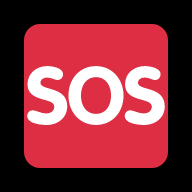

In [68]:
soup

In [ ]:
url=https://twitter.com/search?q=verified%20str(state)%20(bed%20OR%20beds%20OR%20icu%20OR%20oxygen%20OR%20ventilator%20OR%20ventilators)%20-%22not%20verified%22%20-%22unverified%22%20-%22needed%22%20-%22need%22%20-%22needs%22%20-%22required%22%20-%22require%22%20-%22requires%22%20-%22requirement%22%20-%22requirements%22&f=live